In [1]:
import heapq
import numpy as np
import time

class A_Star:
    def __init__(self,boundary,blocks,start,goal,movement):
        self.boundary = boundary
        self.blocks = blocks
        self.move = movement
        self.start = tuple(start)
        self.pos = start
        self.goal = tuple(goal)
        
    def heuristic(self,a, b):
        return np.sqrt((b[0]-a[0])**2+(b[1]-a[1])**2+(b[2]-a[2])**2) 
    
    def label(self,x,gscore):
        if tuple(x) in gscore:
            return gscore.get(tuple(x),0)
        else:
            return np.inf
        
    def check(self,neighbour):
        valid = True
        if( neighbour[0] < self.boundary[0,0]+0.1 or neighbour[0] > self.boundary[0,3]-0.1 or \
            neighbour[1] < self.boundary[0,1]+0.1 or neighbour[1] > self.boundary[0,4]-0.1 or \
            neighbour[2] < self.boundary[0,2]+0.1 or neighbour[2] > self.boundary[0,5]-0.1 ):
            valid = False
        for k in range(self.blocks.shape[0]):
            if( neighbour[0] > self.blocks[k,0]-0.1 and neighbour[0] < self.blocks[k,3]+0.1 and\
                neighbour[1] > self.blocks[k,1]-0.1 and neighbour[1] < self.blocks[k,4]+0.1 and\
                neighbour[2] > self.blocks[k,2]-0.1 and neighbour[2] < self.blocks[k,5]+0.1 ):
                valid = False
        return valid
    
    def neighbours(self,current,move):
        numdir = 26
        neighbour = []
        [dX,dY,dZ] = np.meshgrid([-move,0,move],[-move,0,move],[-move,0,move])
        move_set = np.vstack((dX.flatten(),dY.flatten(),dZ.flatten()))
        move_set = np.delete(move_set,13,axis=1)
        for k in range(numdir):
            new_loc = current + move_set[:,k]
            if np.all([self.check(i) for i in np.array([np.linspace(current[i],new_loc[i],10) for i in range(3)]).transpose()]):
                neighbour.append(new_loc)
        if self.heuristic(neighbour[0],self.goal)<0.5:
            neighbour = [self.goal]
        return neighbour
                
    def A_star(self):
        t0 = time.time()
        gscore = {self.start:0}
        open = []
        close_set = set()
        fscore = {self.start:self.heuristic(self.start, self.goal)}
        heapq.heappush(open,(fscore[self.start],self.start))
        route = {self.start:[self.start]}
        while not self.goal in close_set:
            i = heapq.heappop(open)[1]
            close_set.add(i)
            for j in self.neighbours(i,self.move):
                tmp_g = gscore[i] + self.heuristic(i,j)
                if tuple(j) in close_set:
                    continue
                elif self.label(tuple(j),gscore) > tmp_g:
                    gscore[tuple(j)] = tmp_g
                    route[tuple(j)] = route[i].copy()
                    route[tuple(j)].append(tuple(j))
                    fscore[tuple(j)] = tmp_g+self.heuristic(j,self.goal)
                    heapq.heappush(open,(fscore[tuple(j)],tuple(j)))
        print(route[self.goal])
        data = route[self.goal]
        print('planing time:',time.time()-t0)
        return data

In [2]:
import heapq
import random
import numpy as np
import time

class RRT:
    def __init__(self,boundary,blocks,start,goal,eps):
        self.eps = eps
        self.boundary = boundary
        self.blocks = blocks
        self.start = start
        self.goal = goal
        self.done = False
        self.V = [start]
        self.E = {}
        self.route = []
        
    def heuristic(self,a, b):
        return np.sqrt((b[0]-a[0])**2+(b[1]-a[1])**2+(b[2]-a[2])**2) 
    
    def check(self,neighbour):
        valid = True
        if( neighbour[0] < self.boundary[0,0]+0.1 or neighbour[0] > self.boundary[0,3]-0.1 or \
            neighbour[1] < self.boundary[0,1]+0.1 or neighbour[1] > self.boundary[0,4]-0.1 or \
            neighbour[2] < self.boundary[0,2]+0.1 or neighbour[2] > self.boundary[0,5]-0.1 ):
            valid = False
        for k in range(self.blocks.shape[0]):
            if( neighbour[0] > self.blocks[k,0]-0.1 and neighbour[0] < self.blocks[k,3]+0.1 and\
                neighbour[1] > self.blocks[k,1]-0.1 and neighbour[1] < self.blocks[k,4]+0.1 and\
                neighbour[2] > self.blocks[k,2]-0.1 and neighbour[2] < self.blocks[k,5]+0.1 ):
                valid = False
        return valid 
    
    def samplefree(self):
        [x_min,y_min,z_min] = self.boundary[0,0:3]
        [x_max,y_max,z_max] = self.boundary[0,3:6]
        return np.array([random.uniform(x_min,x_max),random.uniform(y_min,y_max),random.uniform(z_min,z_max)])
    
    def near(self,v,rand):
        x_nearest = [self.heuristic(rand,v[i]) for i in range(len(v))]
        return v[np.argmin(x_nearest)]
  
    def steer(self,nearest,rand):
        if self.heuristic(self.goal,nearest) < 0.7:
            x_new = self.goal
        else:
#             new_dir = (rand-nearest)/np.linalg.norm(rand-nearest)
#             x_new = nearest + self.eps * new_dir
            [dX,dY,dZ] = np.meshgrid([-self.eps,0,self.eps],[-self.eps,0,self.eps],[-self.eps,0,self.eps])
            move_set = np.delete(np.vstack((dX.flatten(),dY.flatten(),dZ.flatten())),13,1)
            neighbour = [nearest + move_set[:,k] for k in range(26)]
            dist = [self.heuristic(rand,neighbour[i]) for i in range(len(neighbour))]
            x_new = neighbour[np.argmin(dist)]
        return x_new
    
    def collisionfree(self,nearest,new):
        return np.all([self.check(i) for i in np.array([np.linspace(new[i],nearest[i],10) for i in range(3)]).transpose()])
    
    def RRT_route(self):
        n = 0
        t0 = time.time()
        while not self.done and n < 100000:
            if n%500 == 0:
                print(n)
            x_rand = self.samplefree()
            x_nearest = self.near(self.V,x_rand)
            x_new = self.steer(x_nearest,x_rand)
            while not self.collisionfree(x_nearest,x_new) or tuple(x_new) in self.E:
                x_rand = self.samplefree()
                x_nearest = self.near(self.V,x_rand)
                x_new = self.steer(x_nearest,x_rand)
            self.V.append(x_new)
            self.E[tuple(x_new)] = x_nearest
            n+=1
            if (x_new == self.goal).all():
                self.V.append(x_new)
                self.E[tuple(x_new)] = x_nearest
                self.route.append(x_new)
                print('planing time:',time.time()-t0)
                self.done = True
                break
        while(np.linalg.norm(self.start-x_new)>1):
            x_new = self.E[tuple(x_new)]
            self.route.append(x_new)
        return self.route

In [11]:
import numpy as np
import time
import threading

import matplotlib;matplotlib.use("TkAgg")
%matplotlib inline

import matplotlib.pyplot as plt; plt.ion()
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# import RobotPlanner
# import A_Star
# import RRT

def tic():
  return time.time()
def toc(tstart, nm=""):
  print('%s took: %s sec.\n' % (nm,(time.time() - tstart)))
  

def load_map(fname):
  mapdata = np.loadtxt(fname,dtype={'names': ('type', 'xmin', 'ymin', 'zmin', 'xmax', 'ymax', 'zmax','r','g','b'),\
                                    'formats': ('S8','f', 'f', 'f', 'f', 'f', 'f', 'f','f','f')})
  blockIdx = mapdata['type'] == b'block'
  boundary = mapdata[~blockIdx][['xmin', 'ymin', 'zmin', 'xmax', 'ymax', 'zmax','r','g','b']].view(('<f4',9))
  blocks = mapdata[blockIdx][['xmin', 'ymin', 'zmin', 'xmax', 'ymax', 'zmax','r','g','b']].view(('<f4',9))
  return boundary, blocks


def draw_map(boundary, blocks, start, goal):
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  hb = draw_block_list(ax,blocks)
  hs = ax.plot(start[0:1],start[1:2],start[2:],'ro',markersize=7,markeredgecolor='k')
  hg = ax.plot(goal[0:1],goal[1:2],goal[2:],'go',markersize=7,markeredgecolor='k')  
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  ax.set_xlim(boundary[0,0],boundary[0,3])
  ax.set_ylim(boundary[0,1],boundary[0,4])
  ax.set_zlim(boundary[0,2],boundary[0,5])  
  return fig, ax, hb, hs, hg

def draw_block_list(ax,blocks):
  v = np.array([[0,0,0],[1,0,0],[1,1,0],[0,1,0],[0,0,1],[1,0,1],[1,1,1],[0,1,1]],dtype='float')
  f = np.array([[0,1,5,4],[1,2,6,5],[2,3,7,6],[3,0,4,7],[0,1,2,3],[4,5,6,7]])
  clr = blocks[:,6:]/255
  n = blocks.shape[0]
  d = blocks[:,3:6] - blocks[:,:3] 
  vl = np.zeros((8*n,3))
  fl = np.zeros((6*n,4),dtype='int64')
  fcl = np.zeros((6*n,3))
  for k in range(n):
    vl[k*8:(k+1)*8,:] = v * d[k] + blocks[k,:3]
    fl[k*6:(k+1)*6,:] = f + k*8
    fcl[k*6:(k+1)*6,:] = clr[k,:]
  
  if type(ax) is Poly3DCollection:
    ax.set_verts(vl[fl])
  else:
    pc = Poly3DCollection(vl[fl], alpha=0.25, linewidths=1, edgecolors='k')
    pc.set_facecolor(fcl)
    h = ax.add_collection3d(pc)
    return h

# import Queue
class route_gen(threading.Thread):
  def __init__(self,func,args=()):
    threading.Thread.__init__(self)
    self.data = []
    self.func = func
    self.args = args

  def run(self):
    self.data = self.func(*self.args)

  def result(self):
      return self.data


def runtest(mapfile, start, goal, verbose = True):
  # Instantiate a robot planner
  boundary, blocks = load_map(mapfile)
  # RP = RobotPlanner.RobotPlanner(boundary, blocks)

  print('Planning....')
#   flag = 1
  flag = 2

  if flag == 1: 
    RP = A_Star(boundary, blocks, start, goal, 0.5)
    print('Treading A* Algorithm ....')
    t = route_gen(RP.A_star)
  elif flag == 2:
    RP = RRT(boundary, blocks, start, goal, 0.4)
    print('Treading RRT Algorithm ....')
    t = route_gen(RP.RRT_route)
  else:
    print('No Flag Value')

  print('Tread starting ....')
  t.start()

  # Display the environment
  if verbose:
    fig, ax, hb, hs, hg = draw_map(boundary, blocks, start, goal)  
  
  # Main loop
  robotpos = np.copy(start)
  numofmoves = 0
  success = True

  print('Entering Map ....\n')

  while True:
  
    # Call the robot planner
    t0 = tic()

    route_loc = t.result()

    if len(route_loc)==0:
      newrobotpos = robotpos
      time.sleep(1)
    else:
      if flag == 1: # use A*
        newrobotpos = np.array(route_loc.pop(0))
      elif flag == 2: # use RRT
        newrobotpos = np.array(route_loc.pop())
      else:
        print('No Flag Value')

    movetime = max(1, np.ceil((tic()-t0)/2.0))
    print('move time: %d' % movetime)

    # See if the planner was done on time
    if movetime > 1:
      newrobotpos = robotpos-0.5 + np.random.rand(3)
  
    # Check if the commanded position is valid
    if sum((newrobotpos - robotpos)**2) > 1:
      print('ERROR: the robot cannot move so fast\n')
      success = False
    if( newrobotpos[0] < boundary[0,0] or newrobotpos[0] > boundary[0,3] or \
        newrobotpos[1] < boundary[0,1] or newrobotpos[1] > boundary[0,4] or \
        newrobotpos[2] < boundary[0,2] or newrobotpos[2] > boundary[0,5] ):
      print('ERROR: out-of-map robot position commanded\n')
      success = False
    for k in range(blocks.shape[0]):
      if( newrobotpos[0] > blocks[k,0] and newrobotpos[0] < blocks[k,3] and\
          newrobotpos[1] > blocks[k,1] and newrobotpos[1] < blocks[k,4] and\
          newrobotpos[2] > blocks[k,2] and newrobotpos[2] < blocks[k,5] ):
        print('ERROR: collision... BOOM, BAAM, BLAAM!!!\n')
        success = False
        break
    if( success is False ):
      break
    
    # Make the move
    trace=np.array([robotpos,newrobotpos])
    robotpos = newrobotpos
    numofmoves += 1
    
    # Update plot
    if verbose:
      ax.plot(trace[:,0],trace[:,1],trace[:,2],color='cyan')
      # hs[0].set_xdata(robotpos[0])
      # hs[0].set_ydata(robotpos[1])
      # hs[0].set_3d_properties(robotpos[2])
      fig.canvas.flush_events()
#       plt.show()
      
    # Check if the goal is reached
    if sum((robotpos-goal)**2) <= 0.1:
      break

  plt.show(block=True)
  return success, numofmoves



def test_single_cube():    
  start = np.array([2.3, 2.3, 1.3])
  goal = np.array([7.0, 7.0, 6.0])
  success, numofmoves = runtest('./maps/single_cube.txt', start, goal, True)
  print('Success: %r'%success)
  print('Number of Moves: %i'%numofmoves)
  
  
def test_maze():
  start = np.array([0.0, 0.0, 1.0])
  goal = np.array([12.0, 12.0, 5.0])
  success, numofmoves = runtest('./maps/maze.txt', start, goal, True)
  print('Success: %r'%success)
  print('Number of Moves: %i'%numofmoves)
  
def test_window():
  start = np.array([0.2, -4.9, 0.2])
  goal = np.array([6.0, 18.0, 3.0])
  success, numofmoves = runtest('./maps/window.txt', start, goal, True)
  print('Success: %r'%success)
  print('Number of Moves: %i'%numofmoves)

def test_tower():
  start = np.array([2.5, 4.0, 0.5])
  goal = np.array([4.0, 2.5, 19.5])
  success, numofmoves = runtest('./maps/tower.txt', start, goal, True)
  print('Success: %r'%success)
  print('Number of Moves: %i'%numofmoves)
 
def test_flappy_bird():
  start = np.array([0.5, 2.5, 5.5])
  goal = np.array([19.0, 2.5, 5.5])
  success, numofmoves = runtest('./maps/flappy_bird.txt', start, goal, True)
  print('Success: %r'%success)
  print('Number of Moves: %i'%numofmoves) 

def test_room():
  start = np.array([1.0, 5.0, 1.5])
  goal = np.array([9.0, 7.0, 1.5])
  success, numofmoves = runtest('./maps/room.txt', start, goal, True)
  print('Success: %r'%success)
  print('Number of Moves: %i'%numofmoves)

def test_monza():
  start = np.array([0.5, 1.0, 4.9])
  goal = np.array([3.8, 1.0, 0.1])
  success, numofmoves = runtest('./maps/monza.txt', start, goal, True)
  print('Success: %r'%success)
  print('Number of Moves: %i'%numofmoves)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/opt/conda/lib/python3.6/site-packages/t

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.


Planning....
Treading A* Algorithm ....
Tread starting ....
Entering Map ....

move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
[(2.3, 2.3, 1.3), (2.8, 2.8, 1.8), (3.3, 3.3, 2.3), (3.3, 3.8, 2.8), (3.8, 4.3, 3.3), (4.3, 4.8, 3.8), (4.8, 5.3, 4.3), (5.3, 5.8, 4.8), (5.8, 6.3, 5.3), (6.3, 6.8, 5.8), (6.8, 6.8, 5.8), (7.3, 7.3, 6.3), (7.0, 7.0, 6.0)]
planing time: 7.93111777305603
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1


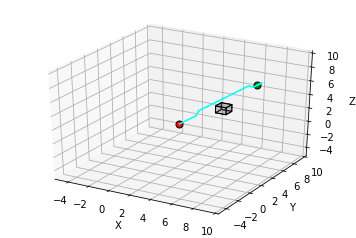

Success: True
Number of Moves: 21


In [4]:
test_single_cube()

Planning....
Treading A* Algorithm ....
Tread starting ....


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.


Entering Map ....

move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move t

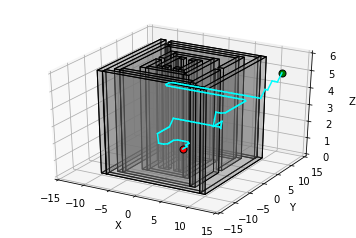

Success: True
Number of Moves: 395


In [5]:
test_maze()

Planning....
Treading A* Algorithm ....
Tread starting ....
Entering Map ....



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.


move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
[(0.5, 2.5, 5.5), (1.0, 2.5, 5.0), (1.0, 2.5, 4.5), (1.5, 2.5, 4.0), (2.0, 2.5, 3.5), (2.5, 2.5, 3.0), (2.5, 2.5, 2.5), (2.5, 2.5, 2.0), (3.0, 2.5, 1.5), (3.5, 2.5, 1.5), (4.0, 2.5, 1.5), (4.5, 2.5, 2.0), (5.0, 2.5, 2.5), (5.5, 2.5, 3.0), (5.5, 2.5, 3.5), (5.5, 2.5, 4.0), (6.0, 2.5, 4.5), (6.5, 2.5, 4.5), (7.0, 2.5, 4.5), (7.5, 2.5, 4.0), (8.0, 2.5, 3.5), (8.5, 2.5, 3.0), (9.0, 2.5, 2.5), (9.0, 2.5, 2.0), (9.5, 2.5, 1.5), (10.0, 2.5, 2.0), (10.5, 2.5, 2.5), (11.0, 2.5, 3.0), (11.5, 2.5, 3.5), (12.0, 2.5, 4.0), (12.5, 2.5, 4.5)

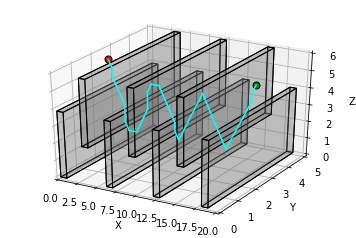

Success: True
Number of Moves: 82


In [6]:
test_flappy_bird()

Planning....
Treading A* Algorithm ....
Tread starting ....
Entering Map ....



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.


move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
[(0.5, 1.0, 4.9), (0.5, 1.5, 4.9), (0.5, 2.0, 4.9), (0.5, 2.5, 4.9), (0.5, 3.0, 4.9), (0.5, 3.5, 4.9), (0.5, 4.0, 4.9), (0.5, 4.5, 4.9), (0.5, 5.0, 4.9), (0.5, 5.5, 4.9), (0.5, 6.0, 4.9), (0.5, 6.5, 4.9), (0.5, 7.0, 4.9), (0.5, 7.5, 4.9), (0.5, 8.0, 4.9), (0.5, 8.5, 4.9), (0.5, 9.0, 4.9), (0.5, 9.5, 4.9), (0.5, 10.0, 4.9), (0.5, 10.5, 4.9), (0.5, 11.0, 4.9), (0.5, 11.5, 4.9), (0.5, 12.0, 4.9), (0.5, 12.5, 4.9), (0.5, 13.0, 4.9), (0.5, 13.5, 4.9), (0.5, 14.0, 4.9), (0.5, 14.5, 4.9), (0.5, 15.0, 4.9), (0.5, 15.5, 4.9), (0.5, 16.0, 4.9), (0.5, 16.5, 4.9), (0.5, 17.0, 4.9), (0.5, 17.5, 4.9), (0.5, 18.0, 4.9), (0.5, 18.5, 4.9), (0.5, 19.0, 4.9), (1.0, 19.5, 4.4), (1.5, 19.0, 3.9000000000000004), (1.5, 18.5, 3.9000000000000004), (1.5, 18.0, 3.9000000000000004), 

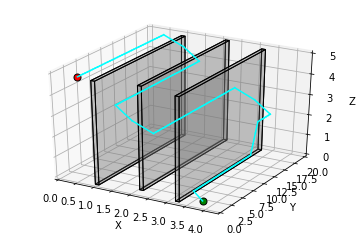

Success: True
Number of Moves: 170


In [7]:
test_monza()

Planning....
Treading A* Algorithm ....
Tread starting ....
Entering Map ....



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.


move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1

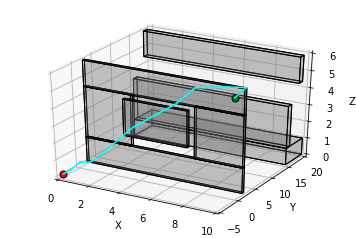

Success: True
Number of Moves: 216


In [8]:
test_window()

Planning....
Treading A* Algorithm ....
Tread starting ....


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.


Entering Map ....

move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1[(2.5, 4.0, 0.5), (3.0, 4.0, 1.0), (3.5, 4.0, 

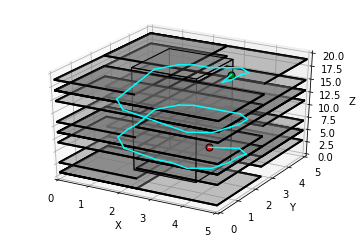

Success: True
Number of Moves: 120


In [9]:
test_tower()

Planning....
Treading A* Algorithm ....
Tread starting ....


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.


Entering Map ....

move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
[(1.0, 5.0, 1.5), (1.5, 4.5, 1.5), (1.5, 4.0, 1.5), (1.5, 3.5, 1.5), (1.5, 3.0, 1.5), (2.0, 2.5, 1.5), (2.5, 3.0, 1.5), (3.0, 3.5, 1.5), (3.5, 4.0, 1.5), (4.0, 4.5, 1.5), (4.5, 4.5, 1.5), (5.0, 4.5, 1.5), (5.5, 4.5, 1.5), (6.0, 4.5, 1.5), (6.5, 4.5, 1.5), (7.0, 4.5, 1.5), (7.5, 5.0, 1.5), (8.0, 5.5, 1.5), (8.5, 6.0, 1.5), (8.5, 6.5, 1.5), (9.0, 7.0, 1.5)]
planing time: 9.122045040130615
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1


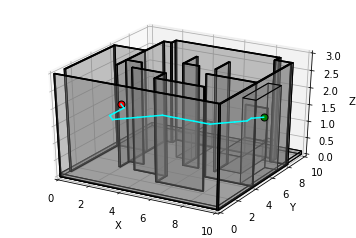

Success: True
Number of Moves: 29


In [10]:
test_room()

## RRT

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.


Planning....
Treading RRT Algorithm ....
Tread starting ....
0
Entering Map ....

planing time: 0.5577325820922852
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1


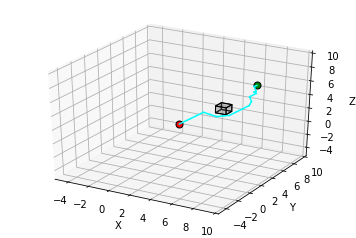

Success: True
Number of Moves: 19


In [12]:
test_single_cube()

Planning....
Treading RRT Algorithm ....
Tread starting ....
0
Entering Map ....



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.


move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
500
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
1000
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
1500
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
2000
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
2500
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
m

move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
planing time: 656.4571390151978
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move t

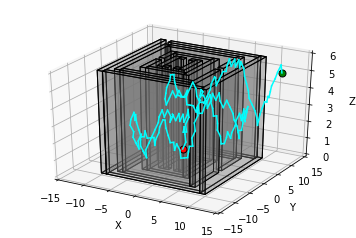

Success: True
Number of Moves: 835


In [13]:
test_maze()

Planning....
Treading RRT Algorithm ....
Tread starting ....
0
Entering Map ....



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.


move time: 1
500
move time: 1
planing time: 2.228821039199829
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
mo

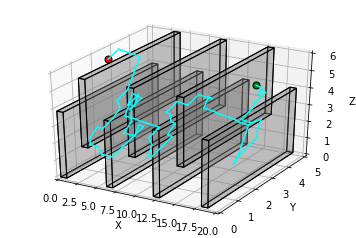

Success: True
Number of Moves: 82


In [14]:
test_flappy_bird()

Planning....
Treading RRT Algorithm ....
Tread starting ....
0
Entering Map ....



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.


move time: 1
move time: 1
500
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
1000
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
1500
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 

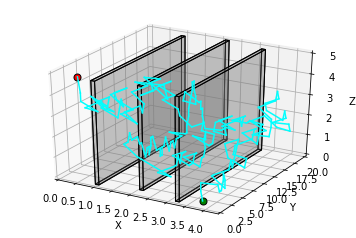

Success: True
Number of Moves: 698


In [15]:
test_monza()

Planning....
Treading RRT Algorithm ....
Tread starting ....
0
Entering Map ....



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.


500
move time: 1
move time: 1
1000
move time: 1
move time: 1
1500
move time: 1
move time: 1
2000
move time: 1
move time: 1
planing time: 8.56699824333191
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
m

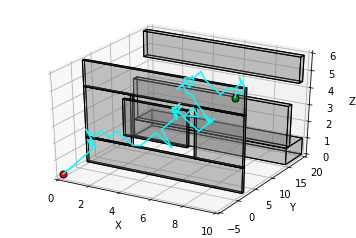

Success: True
Number of Moves: 78


In [16]:
test_window()

Planning....
Treading RRT Algorithm ....
Tread starting ....
0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.


Entering Map ....

move time: 1
move time: 1
move time: 1
move time: 1
500
move time: 1
move time: 1
move time: 1
1000
move time: 1
move time: 1
move time: 1
planing time: 11.498345851898193
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
mov

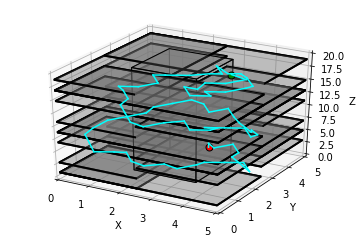

Success: True
Number of Moves: 90


In [17]:
test_tower()

Planning....
Treading RRT Algorithm ....
Tread starting ....
0
Entering Map ....



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.


planing time: 1.0037550926208496
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1
move time: 1


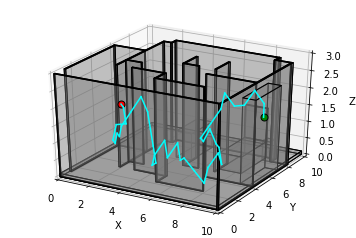

Success: True
Number of Moves: 40


In [18]:
test_room()